In [ ]:
# Implementing FastICA from Scratch
#Implement libraries
import torch
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

In [ ]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1),signal.sawtooth(ns * 1.9)]).T

# Mixing matrix
A = np.array([[0.5, 1],
              [0.4, 0.5]])

# Mixed signal matrix
x = S.dot(A).T
print(x.shape)

(2, 1000)


In [ ]:
#Computing covariance matrix
def covariance(x):
    #Calculate covariance matrix
    return np.cov(x)

#Preprocessing data
#Centering
def centering(x):
    #Calculate mean vector
    mean = np.mean(x, axis=1, keepdims=True)
    centering =  x - mean
    return centering, mean

#Whitening
def whitening(x):
    # Calculate the covariance matrix
    covariance_matrix = covariance(x)

    # Single value decoposition
    U, S, V = np.linalg.svd(covariance_matrix)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whitening_matrix = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    whitening = np.dot(whitening_matrix, x)
    return whitening, whitening_matrix

#Preprocessing data
def preprocessing(x):
    x_centered,mean=centering(x)
    x_whitening,whitening_matrix=whitening(x_centered)
    return x_whitening

In [ ]:
class ICA:
    def __init__(self,x=preprocessing(x),num_iters=5000, threshold=1e-8):
        self.x=x
        self.num_iters=num_iters
        self.threshold=threshold
    
    def FastICA(self):
        m=self.x.shape[0]
        #Initialize random weights
        W=np.random.rand(m,m)
        
        for component in range(m):
            #set W
            w=W[component, :].copy().reshape(m,1)
            #Normalize W
            w=w/np.sqrt((w**2).sum())
            #Num of iteration
            i=0
            #Set limit
            lim=100
            while (lim > self.threshold)&(i<self.num_iters):
                #Calculate dot product of Weights and signals
                ws=np.dot(w.T,self.x)
                #Calculate tanh function
                wg=np.tanh(ws).T
                #Calculate derivative of tanh function
                wg_=(1-np.square(np.tanh(ws)))
                #Update weights
                wNew=(self.x*wg.T).mean(axis=1)-wg_.mean()*w.squeeze()
                #Decorrelate weights
                wNew=wNew-np.dot(np.dot(wNew,W[:component].T),W[:component])
                wNew=wNew/np.sqrt((wNew**2).sum())
                #Calculate limit condition
                lim=np.abs(np.abs((wNew*w).sum())-1)
                #Set new weights
                w=wNew
                i+=1
            #Set weight matrix
            W[component,:]=w.T
        return W
                   
            

In [ ]:
#Fit model FastICA
model=ICA(x=preprocessing(x))
W=model.FastICA()
#Print the Weight matrix
print(W)

[[ 0.06834351  0.99766185]
 [ 0.99766185 -0.06834351]]


In [ ]:
# Center signals
Xc, meanX = centering(x)

# Whiten mixed signals
Xw, whiteM = whitening(Xc)

In [ ]:
#Un-mix signals using 
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

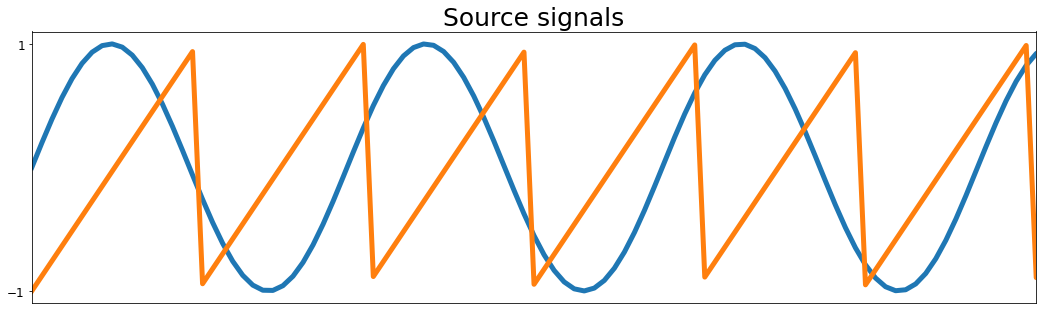

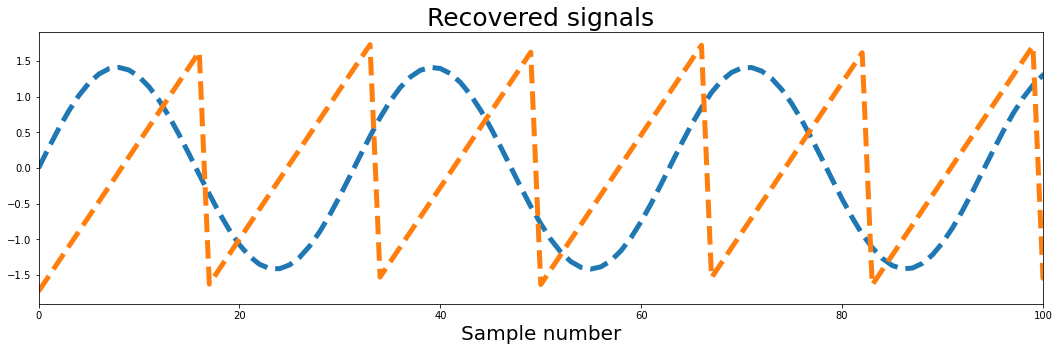

In [ ]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

In [ ]:
weights_fixed = torch.tensor([[1,2],[2,1]],dtype=torch.float,requires_grad=True)
m=torch.from_numpy(preprocessing(x).astype(np.float32))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,w=weights_fixed):
        super(Autoencoder, self).__init__()
        self.w=w
        #Encoder
        self.encoder=nn.Linear(3,3,bias=False)
            
        #Decoder 
        self.decoder=nn.Linear(3,3,bias=False)
        self.encoder.weight = nn.Parameter(self.w)
        self.decoder.weight = nn.Parameter(self.w.transpose(0,1))
        
    def forward(self, m):
      encoded=self.encoder(m)
      decoded=self.decoder(encoded)
      return encoded, decoded

In [ ]:
model=Autoencoder()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-3,eps=1e-4,betas=(0.9,0.95))

In [ ]:
total_loss=[]
for i in range(5000):
  _,x_pred=model(V(m).T)
  loss=1e-4*(torch.linalg.norm(input=x_pred.T-m,ord=2)**2)+torch.sum(torch.log(torch.cosh(_)))
  total_loss.append(loss)
  loss.backward()
  optimizer.step()

In [ ]:
_,x_pred=model(V(m).T)
result=_.detach().numpy()

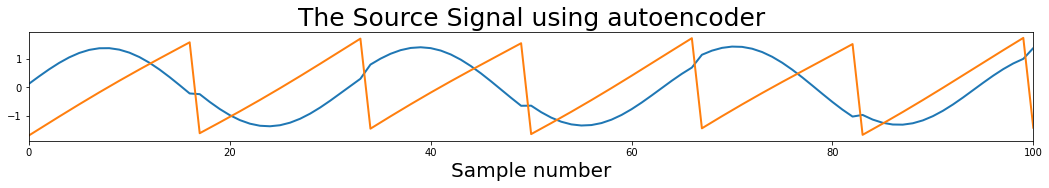

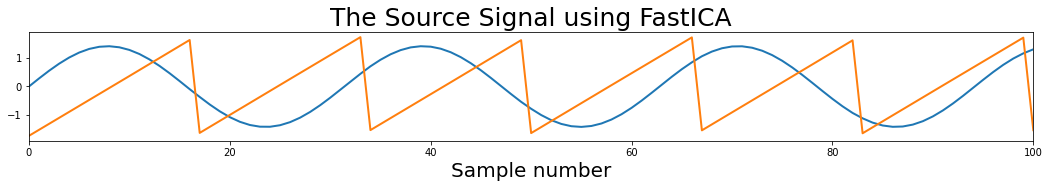

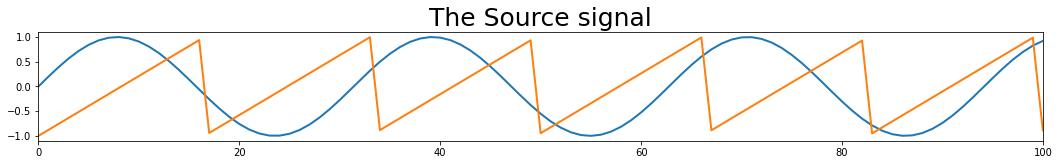

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[18, 2])
ax.plot(result[:,0],'-',lw=2)
ax.plot(result[:,1],'-',lw=2)
ax.set_title('The Source Signal using autoencoder', fontsize=25)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 2])
ax.plot(unMixed, lw=2)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('The Source Signal using FastICA', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 2])
ax.plot(S, lw=2)
ax.set_title('The Source signal', fontsize=25)
ax.set_xlim(0, 100)

plt.show()